<img src="https://gist.githubusercontent.com/nesnoj/6ee605cd3494fa6e3e848385c4afbe19/raw/a883b1bdc69c0c5bbb0b00ba92f43033aa86ec64/dingo_model.png" alt="DINGO Model" width="800"  align="center">

In [1]:
%%capture

from ding0.core import NetworkDing0
from ding0.tools.logger import setup_logger
from ding0.tools.results import save_nd_to_pickle
from ding0.tools.plots import plot_mv_topology
from egoio.tools import db
from sqlalchemy.orm import sessionmaker
import oedialect

from ding0.tools import results


# create new network
nd = NetworkDing0(name='network')



# set ID of MV grid district
mv_grid_districts = [40] # fn

In [2]:
import networkx as nx # nx.draw()

In [3]:
import osmnx as ox

In [4]:
engine = db.connection(section='oedb_dialect', readonly=True)
session = sessionmaker(bind=engine)()

In [5]:
# TODO set in config file
ding0_default=False
retain_all=True

In [6]:
graph, node_coords_dict, row_geo_area = nd.import_mv_grid_districts(session, ding0_default, mv_grid_districts_no=mv_grid_districts)

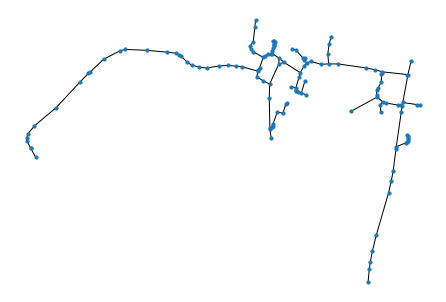

In [7]:
nx.draw(graph, node_coords_dict, node_size=10)

In [8]:
# convert undirected graph to digraph
digraph = nx.MultiGraph(graph)
digraph = digraph.to_directed()
digraph.number_of_edges()


270

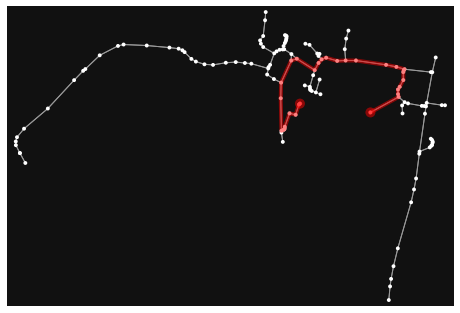

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [9]:
# check shortest path in edges_ding0_digraph
orig=3071953089 
dest=329334521
route_list = ox.distance.shortest_path(digraph, orig, dest, weight='length')
ox.plot.plot_graph_route(digraph, route_list, route_color='r', route_linewidth=4)


In [10]:
from shapely import wkt

In [11]:
poly = wkt.loads(row_geo_area)

In [12]:
# truncate by edge for digraph
truncated_digarph = ox.truncate.truncate_graph_polygon(digraph, poly, retain_all=retain_all, truncate_by_edge=True)

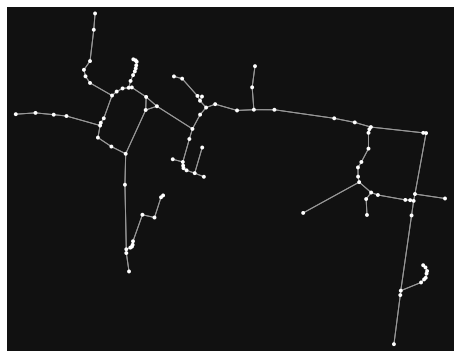

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [13]:
ox.plot_graph(truncated_digarph)

In [14]:
nodes, edges = ox.graph_to_gdfs(truncated_digarph)

In [15]:
import folium

#### PLOTTED DING0 LOAD AREAL INCLUDING GRAPH BUILD BY OSM DB

In [16]:
m = folium.Map([poly.centroid.y, poly.centroid.x], zoom_start=16)
folium.GeoJson(poly).add_to(m)
folium.GeoJson(edges).add_to(m)
m

In [17]:
nx.is_weakly_connected(truncated_digarph)

True

In [18]:
nx.number_weakly_connected_components(truncated_digarph)


1

In [19]:
sub_graph_node_generator = nx.weakly_connected_components(truncated_digarph)

sub_graph_node_list = list(sub_graph_node_generator)
len(sub_graph_node_list)

graph_list = []

for nodes in sub_graph_node_list:
    
    #print(len(nl))
    graph_list.append(graph.subgraph(nodes))
    
    
    # todo: implement allem
    
    
    
len(graph_list)

1

In [ ]:
# TODO LIKE

%%time

# 1. add synthetic nodes to connect buildings in more accurate way
# a ox.get_undirected(graph)
truncated_digraph = ox.get_undirected(graph_list[0])

# TODO check if need to project
truncated_digraph = ox.project_graph(truncated_digraph, to_crs='epsg:3035')

# get graph_subdivided
graph_subdiv = subdivide_graph_edges(truncated_digraph)


In [24]:
nodes, edges = ox.graph_to_gdfs(graph_subdiv)

m = folium.Map([poly.centroid.y, poly.centroid.x], zoom_start=16)
folium.GeoJson(poly).add_to(m)
folium.GeoJson(edges).add_to(m)
folium.GeoJson(nodes).add_to(m)
m

In [ ]:
# todo check if truncate creates subgrpahs
# if len(subgraphs) > 1:
    # there are unconnected subgraphs
    # then for each subgraph
        # cluserting
        # for each cluster
            # build lv_grid_district

In [6]:
load_from_pkl=True

if load_from_pkl:
    
    print('LOAD DING0 GRID FROM PKL')

    grid_id=40
    nd = results.load_nd_from_pickle(filename='./config/tmp/ding0_grids__' + str(grid_id) + '.pkl')
    
    # should be closed before export
    nd.control_circuit_breakers(mode='open')


else:
    
    print('DING0.RUN()')
    
    nd.import_mv_grid_districts(session, ding0_default, mv_grid_districts, need_parameterization)
    nd.import_generators(session)

    nd.mv_parametrize_grid()
    nd.validate_grid_districts()
    
    build_lv_grid_default=True

    if build_lv_grid_default:

        nd.build_lv_grids()

    else:

        print('IMPLEMENT_MY_ROUTING')
        
        
    nd.mv_routing()
    
    nd.connect_generators()
    #nd.set_branch_ids()
    nd.set_circuit_breakers()
    
    
    nd.control_circuit_breakers(mode='open')
    nd.run_powerflow(session)
    
    nd.reinforce_grid()
    
    
    
    #nd.control_circuit_breakers(mode='close')
    #save_nd_to_pickle(nd, filename='ding0_grids__40.pkl')

LOAD DING0 GRID FROM PKL


In [7]:
import networkx as nx # to enable nx.draw()
import pandas as pd
from sqlalchemy import func              # check
from geoalchemy2.shape import to_shape 
from shapely.wkt import loads

In [8]:
from config.config_lv_grids_osm import get_config_osm     # check
from config.db_conn_local import create_session_osm       # check
from config.classes_db_conn.osm_load_classes import Buildings_with_Amenities, Building_wo_Amenity, Amenities_ni_Buildings, Way # check

In [22]:
from grid.lv_grid.routing import build_graph_from_ways, nearest_nodes, get_location_substation_at_pi, subdivide_graph_edges
from grid.lv_grid.parameterization import parameterize_by_load_profiles
from grid.lv_grid.clustering import get_n_cluster, cluster_k_means

In [10]:
from grid.lv_grid.geo import get_Point_from_x_y, get_points_in_load_area, get_convex_hull_from_points

In [11]:
session_osm = create_session_osm() # check

In [12]:
# FOR TESTING REASONS SELECT ONE LOAD_AREA (Fallenbrunnen) BY ID
id_load_area_fallenbrunnen = '4544'

load_areas = []


for mv_grid_district in nd.mv_grid_districts():
    for load_area in mv_grid_district.lv_load_areas():
        
        
        if not load_area.is_aggregated:
                
            if id_load_area_fallenbrunnen in str(load_area):
                
                fn_fallenbrunnen_la  = load_area
                fn_fallenbrunnen_geo = fn_fallenbrunnen_la.geo_area
                
                #for lv_district in fn_fallenbrunnen_la._lv_grid_districts:
                # does not work due to one districtr has 1 lv station where trafo is located
            
                print('build a lv grid for ', str(load_area))
                print('peak_load by ding0', load_area.peak_load)
                print('STARTING SYNTHESIZING LV GRIDS FOR load_area')

                print('CALL')

                print('SYNTHESIZING LV GRIDS for LA TERMINATED')
                
                
        # if only is_aggregated
        #    indent
        load_areas.append(load_area)
                                
                

build a lv grid for  lv_load_area_4544
peak_load by ding0 27.9485612387548
STARTING SYNTHESIZING LV GRIDS FOR load_area
CALL
SYNTHESIZING LV GRIDS for LA TERMINATED


In [13]:
type(fn_fallenbrunnen_la._lv_grid_districts[0])

ding0.core.structure.regions.LVGridDistrictDing0

In [14]:
fn_fallenbrunnen_la._lv_grid_districts[0].__dict__

{'id_db': 4563,
 'geo_data': <shapely.geometry.multipolygon.MultiPolygon at 0x29fd44d0430>,
 'lv_load_area': lv_load_area_4544,
 'lv_grid': lv_grid_4563,
 'population': 80,
 'peak_load_residential': 27.9485612387548,
 'peak_load_retail': 0.0,
 'peak_load_industrial': 0.0,
 'peak_load_agricultural': 0.0,
 'peak_load': 27.9485612387548,
 'sector_count_residential': 1,
 'sector_count_retail': 0,
 'sector_count_industrial': 0,
 'sector_count_agricultural': 0,
 'sector_consumption_residential': 130771.856816184,
 'sector_consumption_retail': 0.0,
 'sector_consumption_industrial': 0.0,
 'sector_consumption_agricultural': 0.0}

In [15]:
fn_fallenbrunnen_la.id_db

4544

In [16]:
fn_fallenbrunnen_geo = fn_fallenbrunnen_la.geo_area

In [17]:
#fn_fallenbrunnen_geo.wkt

In [18]:
from shapely import geometry

In [19]:
# schnetzenhausen geo
G_east  = 9.4467
G_south = 47.6718
G_north = 47.6790
G_west  = 9.4341

p1 = geometry.Point(G_east,G_south)
p2 = geometry.Point(G_east,G_north)
p3 = geometry.Point(G_west,G_north)
p4 = geometry.Point(G_west,G_south)

pointList = [p1, p2, p3, p4, p1]

area_of_interest = geometry.Polygon([[p.x, p.y] for p in pointList])

area_of_interest.wkt

'POLYGON ((9.4467 47.6718, 9.4467 47.679, 9.434100000000001 47.679, 9.434100000000001 47.6718, 9.4467 47.6718))'

In [20]:
# load ways and buildings...

### Load bays
#ways = session_osm.query(Way).filter(func.st_intersects(func.ST_GeomFromText(fn_fallenbrunnen_geo.wkt, get_config_osm('srid')), Way.geometry)) 
ways = session_osm.query(Way).filter(func.st_intersects(func.ST_GeomFromText(area_of_interest.wkt, get_config_osm('srid')), Way.geometry)) 


graph, node_coords_dict = build_graph_from_ways(ways)
#nx.draw(graph, node_coords_dict)


### Load buildings_w_a
#buildings_w_a = session_osm.query(Buildings_with_Amenities).filter(func.st_intersects(func.ST_GeomFromText(fn_fallenbrunnen_geo.wkt, get_config_osm('srid')), Buildings_with_Amenities.geometry_amenity)) 
buildings_w_a = session_osm.query(Buildings_with_Amenities).filter(func.st_intersects(func.ST_GeomFromText(area_of_interest.wkt, get_config_osm('srid')), Buildings_with_Amenities.geometry_amenity)) 

### Load buildings_wo_a
#buildings_wo_a = session_osm.query(Building_wo_Amenity).filter(func.st_intersects(func.ST_GeomFromText(fn_fallenbrunnen_geo.wkt, config_osm['srid']), Building_wo_Amenity.geometry)) 
buildings_wo_a = session_osm.query(Building_wo_Amenity).filter(func.st_intersects(func.ST_GeomFromText(area_of_interest.wkt, get_config_osm('srid')), Building_wo_Amenity.geometry)) 

### Load buildings_wo_a
#amenities_ni_Buildings = session_osm.query(Amenities_ni_Buildings).filter(func.st_intersects(func.ST_GeomFromText(fn_fallenbrunnen_geo.wkt, config_osm['srid']), Amenities_ni_Buildings.geometry)) 
amenities_ni_Buildings = session_osm.query(Amenities_ni_Buildings).filter(func.st_intersects(func.ST_GeomFromText(area_of_interest.wkt, get_config_osm('srid')), Amenities_ni_Buildings.geometry)) 


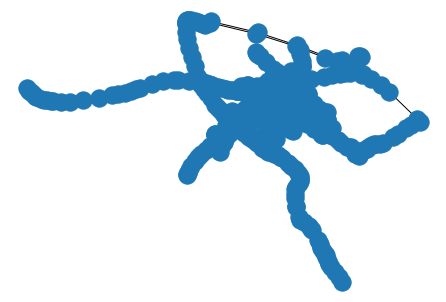

In [21]:
nx.draw(graph, node_coords_dict)

#### ADD LOADS and ASSIGN NN

In [22]:
%%time

# parameterization
buildings_w_loads_df = parameterize_by_load_profiles(buildings_w_a, buildings_wo_a, amenities_ni_Buildings)

# adding nearest nodes
X = buildings_w_loads_df['x'].tolist()
Y = buildings_w_loads_df['y'].tolist()
    
buildings_w_loads_df['nn'], buildings_w_loads_df['nn_dist'] = nearest_nodes(graph, X, Y)

Wall time: 2.42 s


In [23]:
buildings_w_loads_df.head()

,category,capacity,area,number_households,x,y,geometry,raccordement_building,nn,nn_dist
osm_id,,,,,,,,,,
5175135665,place_of_worship,10.000000,100,0,9.44044,47.678088,POINT (9.4404395 47.67808800001318),POINT (9.4404395 47.67808800001318),2081001741,7.859250
1576076796,pub,60.977231,666.345,3.4,9.441255,47.675475,"POLYGON ((9.4410905 47.67549720001377, 9.44114...",POINT (9.441254552977929 47.67547454660144),1863459034,17.760880
3461383409,restaurant,150.911429,3298.25,2.16,9.441726,47.675793,"POLYGON ((9.441379400000001 47.67584520001369,...",POINT (9.441725733550514 47.67579283860851),2457005968,30.049377
8598838279,ice_cream,20.966863,229.121,0.645161,9.437183,47.674769,"POLYGON ((9.437094099999998 47.67477800001394,...",POINT (9.437183076702567 47.67476938145773),475940044,19.021132
143475111,residential,0.427118,100,0.25,9.442517,47.676217,"POLYGON ((9.4421704 47.67620580001361, 9.44254...",POINT (9.442516566727749 47.67621714946911),3461383425,29.441108


In [24]:
buildings_w_loads_df.to_csv('buildings_w_loads_df_schnetzenhausen.csv')

### Clustering

In [27]:
n_clusters = get_n_cluster(buildings_w_loads_df)
if n_clusters < len(fn_fallenbrunnen_la._lv_grid_districts):
    n_clusters = len(fn_fallenbrunnen_la._lv_grid_districts)
buildings_w_loads_df = cluster_k_means(buildings_w_loads_df, n_clusters)

In [29]:
n_clusters

3

### Update and add _districts

In [30]:
for i in range(n_clusters):
    
    print(len(buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==i)]))


99
85
79


In [28]:
buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)]

,category,capacity,area,number_households,x,y,geometry,raccordement,nn,nn_dist,Cluster
osm_id,,,,,,,,,,,
8598838279,ice_cream,20.966863,229.121,0.645161,9.437183,47.674769,"POLYGON ((9.437094099999998 47.67477800001394,...",POINT (9.437183076702567 47.67476938145773),475940044,19.021132,0
144020300,public_building,244.695822,2113.09,0.8125,9.438239,47.675506,"POLYGON ((9.437905999999998 47.67551250001376,...",POINT (9.438238891069723 47.67550616796044),1576023053,34.831012,0
144023114,school,102.108142,1641.61,0.552632,9.438521,47.673818,"POLYGON ((9.438203599999998 47.67375600001416,...",POINT (9.438521488700175 47.67381754064048),68844093,33.677840,0
314909001,residential,1.246721,100,0.72973,9.43711,47.674319,"POLYGON ((9.4370154 47.67431780001401, 9.43711...",POINT (9.437109750000001 47.67431900001404),2080880814,14.638173,0
314909020,house,1.102239,100,0.645161,9.437548,47.674401,"POLYGON ((9.4374646 47.674413400014, 9.4375446...",POINT (9.437548450000001 47.67440130001403),314975344,15.374000,0
...,...,...,...,...,...,...,...,...,...,...,...
314913916,residential,2.904399,100,1.7,9.436301,47.672468,"POLYGON ((9.436173800000001 47.67246730001447,...",POINT (9.436301343479869 47.67246766666069),311379901,30.431139,0
338514542,school,407.558658,6552.39,0.594203,9.438414,47.673881,"POLYGON ((9.437957300000001 47.67387860001414,...",POINT (9.438414351486788 47.67388107322754),68844093,31.901109,0
401560706,residential,1.102239,100,0.645161,9.43769,47.674448,"POLYGON ((9.4376228 47.674467300014, 9.4377058...",POINT (9.437690147469656 47.67444791593603),314975344,27.030240,0


In [16]:
%%time

geometry = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0), 'geometry'].tolist()

points = get_points_in_load_area(geometry)
        
len(points)

Wall time: 9.38 ms


140

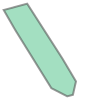

In [17]:
get_convex_hull_from_points(points)

In [24]:
fn_fallenbrunnen_la.lv_load_area_group.__dict__

{'id_db': 20,
 'mv_grid_district': mv_grid_district_40,
 '_lv_load_areas': [lv_load_area_4544,
  lv_load_area_4545,
  lv_load_area_4548,
  MVCableDist_mvgd_40_26],
 'peak_load': 65.35928151751943,
 'branch_length_sum': 0,
 'peak_load_max': 1000.0,
 'branch_length_max': 2000.0,
 'root_node': MVCableDist_mvgd_40_23}

In [28]:
nd._mv_grid_districts[0].__dict__

{'id_db': 40,
 'mv_grid': mv_grid_40,
 '_lv_load_areas': [lv_load_area_2128,
  lv_load_area_2292,
  lv_load_area_2383,
  lv_load_area_2520,
  lv_load_area_2521,
  lv_load_area_2561,
  lv_load_area_2608,
  lv_load_area_2625,
  lv_load_area_2633,
  lv_load_area_2705,
  lv_load_area_2728,
  lv_load_area_2763,
  lv_load_area_2765,
  lv_load_area_2840,
  lv_load_area_2842,
  lv_load_area_3029,
  lv_load_area_3088,
  lv_load_area_3089,
  lv_load_area_3119,
  lv_load_area_3160,
  lv_load_area_3235,
  lv_load_area_3277,
  lv_load_area_3304,
  lv_load_area_3305,
  lv_load_area_3307,
  lv_load_area_3311,
  lv_load_area_3314,
  lv_load_area_3403,
  lv_load_area_3413,
  lv_load_area_3645,
  lv_load_area_3661,
  lv_load_area_3731,
  lv_load_area_3780,
  lv_load_area_3805,
  lv_load_area_3911,
  lv_load_area_3986,
  lv_load_area_3987,
  lv_load_area_3992,
  lv_load_area_4212,
  lv_load_area_4337,
  lv_load_area_4347,
  lv_load_area_4487,
  lv_load_area_4488,
  lv_load_area_4544,
  lv_load_area_4545,

In [17]:
fn_fallenbrunnen_la._lv_grid_districts[0].lv_grid._station.__dict__

{'id_db': 4563,
 'geo_data': <shapely.geometry.point.Point at 0x118800eba90>,
 'grid': lv_grid_4563,
 '_transformers': [Transformer_lv_grid_4563_1],
 'v_level_operation': None,
 'lv_load_area': lv_load_area_4544,
 'voltage_res': [0.9897135909377942, 1.0123145234795161]}

In [17]:
preprocessed_clusters = []   
    

for cluster_id in range(n_clusters):
    
    if cluster_id < len(fn_fallenbrunnen_la._lv_grid_districts):
        
        print('delete or update _lv_grid_districts[', cluster_id, ']')
        
        # GET NEW VALUES FOR DISTRICT        
        # get convex hull of cluster
        points = get_points_in_load_area(buildings_w_loads_df.loc[buildings_w_loads_df['Cluster']==cluster_id])
        district_convex_hull = get_convex_hull_from_points(points)
        
        # get location of substation for cluster
        station_x, station_y = get_location_substation_at_pi(graph, buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)])

        
        # UPDATE VALUES
        # update values of _lv_grid_districts[cluster_id]
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].geo_data  = district_convex_hull
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].poulation = buildings_w_loads_df.loc[buildings_w_loads_df['Cluster']==cluster_id]['number_households'].sum()
        
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].peak_load = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==0)]['capacity'].sum()
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].peak_load_residential = buildings_w_loads_df.loc[(buildings_w_loads_df['Cluster']==cluster_id) & buildings_w_loads_df['number_households'] > 0]['capacity'].sum()
        
        
        # ADD / RESET DING0 ELEMENTS
        # update position of substation
        fn_fallenbrunnen_la._lv_grid_districts[0].lv_grid._station.geo_data = get_Point_from_x_y(station_x, station_y)
        
        # reset list to add new elements
        fn_fallenbrunnen_la._lv_grid_districts[cluster_id].lv_grid._station.transformers.clear()
        
        
        # update trafo and loads
        #fn_fallenbrunnen_la._lv_grid_districts[cluster_id].lv_grid.build_grid()
        
        
    else:
        
        print('add _lv_grid_districts id', cluster_id)
        
        
        
        
        
    break
    

update _lv_grid_districts 0
add _lv_grid_districts id 1
add _lv_grid_districts id 2


In [21]:
fn_fallenbrunnen_la._lv_grid_districts[0].lv_grid._station.__dict__

{'id_db': 4563,
 'geo_data': <shapely.geometry.point.Point at 0x1d50cd257f0>,
 'grid': lv_grid_4563,
 '_transformers': [Transformer_lv_grid_4563_1],
 'v_level_operation': None,
 'lv_load_area': lv_load_area_4544,
 'voltage_res': [0.9897135909377942, 1.0123145234795161]}

In [19]:
#lv_district_of_interest.lv_grid.graph_draw(mode='LV')

In [16]:
lv_district_of_interest.lv_grid.__dict__ # .geo_data.wkt

NameError: name 'lv_district_of_interest' is not defined

In [19]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

In [20]:
X = []    # collect nodes

for node in graph.nodes:

    X.append([graph.nodes[node]['X'], graph.nodes[node]['Y']])
    
    
X = np.array(X)



# clustering

adj_mat_sparse = nx.adjacency_matrix(graph, weight='length')

clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=adj_mat_sparse).fit(X)






# assign cluster labels

i_label = 0

for node in list(graph.nodes):

    graph.nodes[node]['cluster'] = clustering.labels_[i_label]
    
    i_label += 1
    
labels = nx.get_node_attributes(graph, 'cluster') 

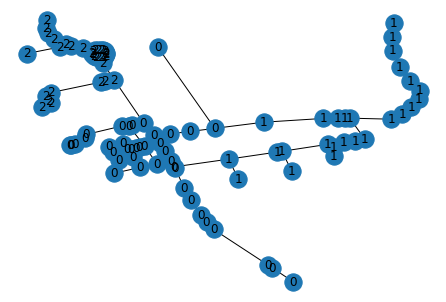

In [23]:
nx.draw(graph, node_coords_dict,labels=labels)

In [24]:
X = []    # collect nodes

for node in graph.nodes:

    X.append([graph.nodes[node]['X'], graph.nodes[node]['Y']])
    
    
X = np.array(X)



# clustering

adj_mat_sparse = nx.to_numpy_matrix(graph, weight='length')

clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', connectivity=adj_mat_sparse).fit(X)






# assign cluster labels

i_label = 0

for node in list(graph.nodes):

    graph.nodes[node]['cluster'] = clustering.labels_[i_label]
    
    i_label += 1
    
labels = nx.get_node_attributes(graph, 'cluster') 

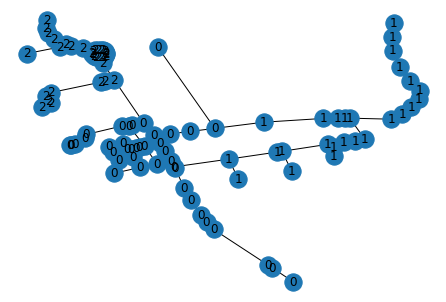

In [25]:
nx.draw(graph, node_coords_dict,labels=labels)